# Movie Data NLP Feature Engineering Notebook

## Step 0: Import Libraries and Load Data

In [ ]:
# Import necessary libraries
import pandas as pd
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import re
import ast

# Load data
df = pd.read_csv('clean_movie_data.csv')

# Display dataset overview
df.head()

/Users/austinevans/MGT8833/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,country_australia,country_italy,country_spain,country_china,country_japan,release_year,adjusted_budget,adjusted_revenue,ROI,number_of_cast
0,315011,Shin Godzilla,"[{""cast_id"": 4, ""character"": ""Rando Yaguchi : ...","[{""credit_id"": ""5921d321c3a368799b05933f"", ""de...",15000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",0,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 7671,...",ja,シン・ゴジラ,...,0,0,0,0,1,2016,15195000.0,7.800100e+07,413.333333,49
1,50321,Mars Needs Moms,"[{""cast_id"": 3, ""character"": ""Milo (voice)"", ""...","[{""credit_id"": ""52fe47c3c3a36847f8146d59"", ""de...",150000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",1,"[{""id"": 5202, ""name"": ""boy""}, {""id"": 9951, ""na...",en,Mars Needs Moms,...,0,0,0,0,0,2011,154800000.0,4.024053e+07,-74.004828,12
2,11619,Flushed Away,"[{""cast_id"": 1, ""character"": ""Roddy"", ""credit_...","[{""credit_id"": ""52fe44699251416c75033c9b"", ""de...",149000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",1,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,Flushed Away,...,0,0,0,0,0,2006,153768000.0,6.652201e+07,-56.738714,15
3,266647,Pan,"[{""cast_id"": 9, ""character"": ""Peter Pan"", ""cre...","[{""credit_id"": ""57373a28925141136e003ec3"", ""de...",150000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 10751...",0,"[{""id"": 334, ""name"": ""flying""}, {""id"": 2343, ""...",en,Pan,...,0,0,0,0,0,2015,150150000.0,1.285167e+08,-14.407787,19
4,2310,Beowulf,"[{""cast_id"": 24, ""character"": ""Beowulf / Golde...","[{""credit_id"": ""52fe434cc3a36847f8049c1b"", ""de...",70000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",1,"[{""id"": 509, ""name"": ""denmark""}, {""id"": 2037, ...",en,Beowulf,...,0,0,0,0,0,2007,72030000.0,2.014122e+08,179.622680,30


In [3]:
# Download NLTK resources & spacy resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austinevans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austinevans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/austinevans/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.3 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Step 1: Topic Modeling for Themes

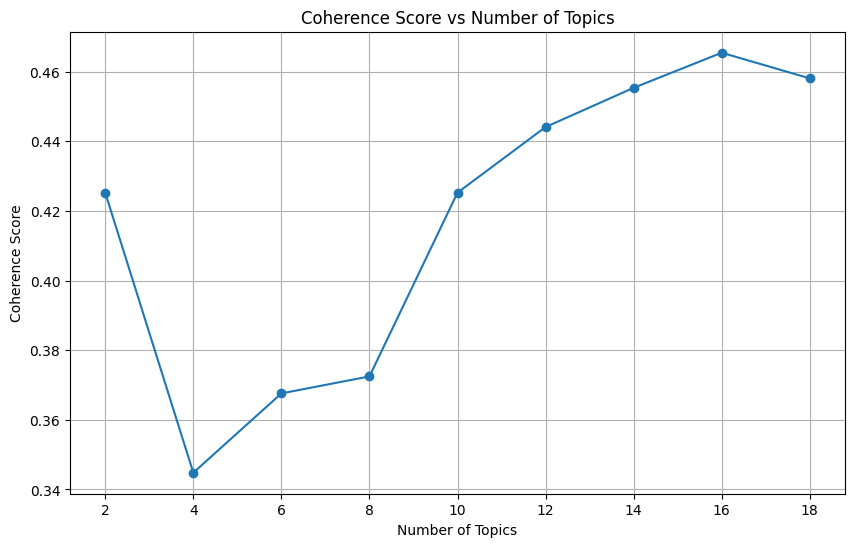

Optimal number of topics: 16

Top Words Per Topic:
Topic 0: 0.018*"homeless" + 0.012*"relationship" + 0.012*"homosexuality" + 0.012*"jazz" + 0.011*"woman" + 0.010*"overdose" + 0.010*"person" + 0.009*"war" + 0.009*"white" + 0.009*"teenage"
Topic 1: 0.025*"relationship" + 0.021*"sister" + 0.015*"adult" + 0.015*"school" + 0.012*"young" + 0.011*"teacher" + 0.011*"woman" + 0.010*"capitalism" + 0.010*"friends" + 0.008*"father"
Topic 2: 0.019*"sex" + 0.015*"friends" + 0.014*"hotel" + 0.013*"virginity" + 0.012*"woman" + 0.012*"pedophilia" + 0.011*"abuse" + 0.011*"drug" + 0.011*"anger" + 0.011*"new"
Topic 3: 0.021*"gay" + 0.018*"comedy" + 0.015*"violence" + 0.014*"dark" + 0.012*"comic" + 0.012*"bomb" + 0.011*"book" + 0.010*"zombie" + 0.010*"gun" + 0.009*"murder"
Topic 4: 0.036*"woman" + 0.025*"relationship" + 0.014*"lesbian" + 0.014*"secretary" + 0.014*"walking" + 0.011*"christian" + 0.010*"daughter" + 0.010*"pedophilia" + 0.009*"pedophile" + 0.008*"chase"
Topic 5: 0.024*"drug" + 0.021*"gay" + 

,title_x,keywords_processed,dominant_topic,dominant_topic_score
0,Shin Godzilla,monster godzilla giant monster destruction kai...,10.0,0.882734
1,Mars Needs Moms,boy alien rescue martian alien abduction alien...,6.0,0.295742
2,Flushed Away,london england underworld return ship frog gir...,11.0,0.765252
3,Pan,flying magic fairy tale peter pan mermaid pira...,7.0,0.650788
4,Beowulf,denmark nordic mythology lie pride and vanity ...,3.0,0.611509


In [4]:
# Preprocess 'keywords' column
def extract_keywords(keyword_data):
    # Parse the JSON-like string into Python objects
    try:
        keywords_list = ast.literal_eval(keyword_data)
        return ' '.join([keyword['name'] for keyword in keywords_list])
    except (ValueError, TypeError):
        return ''

df['keywords_processed'] = df['keywords'].fillna('').apply(extract_keywords)

# Tokenize and clean keywords for Gensim
stop_words = set(stopwords.words('english'))
movie_words = ["film", "independent", "based", "storyline", "director","duringcreditsstinger", "aftercreditsstinger", "actor", "actress"]
stop_words.update(movie_words)

def preprocess_keywords(text):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove special characters and convert to lowercase
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]  # Remove stopwords

df['keywords_tokenized'] = df['keywords_processed'].apply(preprocess_keywords)

# Create Gensim Dictionary and Corpus
dictionary = corpora.Dictionary(df['keywords_tokenized'])
corpus = [dictionary.doc2bow(text) for text in df['keywords_tokenized']]

# Function to compute coherence values for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=15, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Train the LDA model
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(lda_model)
        # Compute the coherence score
        coherence_model = models.coherencemodel.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Compute coherence scores
start, limit, step = 2, 20, 2  # Adjust the range as needed
model_list, coherence_values = compute_coherence_values(dictionary, corpus, df['keywords_tokenized'], start, limit, step)

# Plot coherence scores
plt.figure(figsize=(10, 6))
x = range(start, limit, step)
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.xticks(x)
plt.grid()
plt.show()

# Find the optimal number of topics
optimal_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_topics}")

# Re-train LDA with the optimal number of topics
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topics, random_state=0)

# Print the top words per topic
print("\nTop Words Per Topic:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")

# Add the dominant topic to the DataFrame
def get_dominant_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0] if topics else -1

df['dominant_topic'] = [get_dominant_topic(lda_model, bow) for bow in corpus]

# Function to compute dominant topic score
def get_dominant_topic_score(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    dominant_topic = max(topics, key=lambda x: x[1])[0] if topics else -1
    # Get the score of the dominant topic
    score = max(topics, key=lambda x: x[1])[1] if topics else 0
    return dominant_topic, score

# Apply to each document (movie)
df[['dominant_topic', 'dominant_topic_score']] = df['keywords_tokenized'].apply(
    lambda x: pd.Series(get_dominant_topic_score(lda_model, dictionary.doc2bow(x)))
)

# Display updated DataFrame with dominant topics and scores
df[['title_x', 'keywords_processed', 'dominant_topic', 'dominant_topic_score']].head()

In [ ]:
# Initialize an empty list to store topics and their words and scores
topics_data = []

# Loop through topics and extract data
for idx, topic in lda_model.print_topics(num_words=10):
    topic_row = {"Topic Id": idx}
    for i, word_score in enumerate(topic.split(" + ")):
        score, word = word_score.split("*")
        topic_row[f"#{i+1} word score"] = float(score)
        topic_row[f"#{i+1} word"] = word.strip('"')
    topics_data.append(topic_row)

# Create a DataFrame
topics_df = pd.DataFrame(topics_data)
print(topics_df)

topics_df.to_csv('topics.csv')

    Topic Id  #1 word score       #1 word  #2 word score       #2 word  \
0          0          0.018      homeless          0.012  relationship   
1          1          0.025  relationship          0.021        sister   
2          2          0.019           sex          0.015       friends   
3          3          0.021           gay          0.018        comedy   
4          4          0.036         woman          0.025  relationship   
5          5          0.024          drug          0.021           gay   
6          6          0.016    wilderness          0.011   personality   
7          7          0.024       teenage          0.023           sex   
8          8          0.019  relationship          0.013       brother   
9          9          0.058          drug          0.016        addict   
10        10          0.024          love          0.017       student   
11        11          0.025        murder          0.024          town   
12        12          0.018  relations

## Step 2: Named Entity Recognition (NER) for High-Value Actors and Directors

In [4]:
# helper data
Actors_df = pd.read_csv('100_Greatest_Actors.csv')
Directors_df = pd.read_csv('25_Greatest_Directors.csv')
Actors_list= Actors_df['Name'].tolist()
Directors_list = Directors_df['Name'].tolist()

# quick check
print(Actors_list)
print(Directors_list)

['Jack Nicholson', 'Marlon Brando', 'Robert De Niro', 'Al Pacino', 'Daniel Day-Lewis', 'Dustin Hoffman', 'Tom Hanks', 'Anthony Hopkins', 'Paul Newman', 'Denzel Washington', 'Spencer Tracy', 'Laurence Olivier', 'Jack Lemmon', 'Michael Caine', 'James Stewart', 'Robin Williams', 'Robert Duvall', 'Sean Penn', 'Morgan Freeman', 'Jeff Bridges', 'Sidney Poitier', "Peter O'Toole", 'Clint Eastwood', 'Gene Hackman', 'Charles Chaplin', 'Ben Kingsley', 'Philip Seymour Hoffman', 'Leonardo DiCaprio', 'Russell Crowe', 'Kevin Spacey', 'Humphrey Bogart', 'Gregory Peck', 'Clark Gable', 'Gary Cooper', 'George C. Scott', 'Jason Robards', 'Charles Laughton', 'Anthony Quinn', 'Peter Sellers', 'James Cagney', 'Peter Finch', 'Henry Fonda', 'Cary Grant', 'Richard Burton', 'Burt Lancaster', 'William Holden', 'John Wayne', 'Kirk Douglas', 'Alec Guinness', 'Christopher Plummer', 'Tommy Lee Jones', 'Sean Connery', 'Alan Arkin', 'Christopher Walken', 'Joe Pesci', 'Ian McKellen', 'Michael Douglas', 'Jon Voight', 'Al

In [5]:
def extract_important_names(cast_data, crew_data):
    cast, crew = ast.literal_eval(cast_data), ast.literal_eval(crew_data)
    
    # Extract names and roles
    cast_names = [person['name'] for person in cast if person['name'] in Actors_list]
    directors = [person['name'] for person in crew if person.get('job') == 'Director' and person['name'] in Directors_list]
    
    return len(cast_names), len(directors)

# Apply the function to the dataframe and create new columns
df['high_value_actors'], df['high_value_directors'] = zip(*df.apply(
    lambda x: extract_important_names(x['cast'], x['crew']), axis=1))

# Display the result
df[['high_value_actors', 'high_value_directors']]

,high_value_actors,high_value_directors
0,0,0
1,0,0
2,2,0
3,1,0
4,1,0
...,...,...
2175,0,0
2176,0,0
2177,0,0
2178,0,0


In [6]:
print(df['high_value_actors'].value_counts())
print('\n')
print(df['high_value_directors'].value_counts())

high_value_actors
0    1524
1     495
2     129
3      28
4       4
Name: count, dtype: int64


high_value_directors
0    2094
1      86
Name: count, dtype: int64


## Step 3: Sentiment Analysis for Overview Emotional Tone

In [7]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if you are using GPU)

2.5.1
False


In [ ]:
def clean_text(text):
    text = re.sub(r"[^\w\s]", "", text)        # Remove punctuation
    text = text.lower().strip()               # Lowercase and trim
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in stop_words])

# Apply text cleaning
df['overview_cleaned'] = df['overview'].fillna("").apply(clean_text)

# Handle empty overviews
df['overview_cleaned'] = df['overview_cleaned'].replace("", "neutral text")

# Truncate long overviews for BERT input limit
df['overview_truncated'] = df['overview_cleaned'].apply(lambda x: x[:512])

# Step 2: Define Sentiment Analysis Pipeline
# Load the transformer
sentiment_analyzer = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english", 
    framework="pt", 
    device=-1
)

def safe_get_sentiment_label(text):
    """Get sentiment label and score with error handling."""
    try:
        result = sentiment_analyzer(text)[0]
        return result['label'], result['score']
    except Exception as e:
        return "neutral", 0.0  # Default for errors

# Step 3: Apply Sentiment Analysis on 'overview'
df[['sentiment_label', 'sentiment_score']] = df['overview_truncated'].apply(
    lambda text: pd.Series(safe_get_sentiment_label(text) if pd.notna(text) else ('neutral', 0)))

# Step 4: Add Confidence Level
def categorize_confidence(score):
    """Categorize confidence levels based on sentiment score."""
    if score > 0.8:
        return "high"
    elif score > 0.5:
        return "medium"
    else:
        return "low"

df['confidence_level'] = df['sentiment_score'].apply(categorize_confidence)

# Step 5: Quality Checks
# Display basic statistics
print("Sentiment Label Counts:\n", df['sentiment_label'].value_counts())
print("\nSentiment Score Summary:\n", df['sentiment_score'].describe())

# Display sample results
print(df[['overview_cleaned', 'sentiment_label', 'sentiment_score', 'confidence_level']].head(10))

Sentiment Label Counts:
 sentiment_label
NEGATIVE    1319
POSITIVE     861
Name: count, dtype: int64

Sentiment Score Summary:
 count    2180.000000
mean        0.936916
std         0.103348
min         0.500496
25%         0.935133
50%         0.981488
75%         0.994269
max         0.999862
Name: sentiment_score, dtype: float64
                                    overview_cleaned sentiment_label  \
0  mind behind evangelion comes hit larger life m...        NEGATIVE   
1  martians suddenly abduct mom mischievous milo ...        POSITIVE   
2  london highsociety mouse roddy flushed toilet ...        NEGATIVE   
3  living bleak existence london orphanage 12year...        POSITIVE   
4  6thcentury scandinavian warrior beowulf embark...        POSITIVE   
5        common thief joins mythical god quest egypt        POSITIVE   
6  deeply ensconced topsecret military program th...        POSITIVE   
7  gritty alternate 1985 glory days costumed vigi...        POSITIVE   
8  scouring ocean 

In [9]:
print(df.columns)

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count',
       'genre_science_fiction', 'genre_music', 'genre_tv_movie',
       'genre_romance', 'genre_comedy', 'genre_western', 'genre_fantasy',
       'genre_drama', 'genre_thriller', 'genre_crime', 'genre_history',
       'genre_animation', 'genre_foreign', 'genre_war', 'genre_documentary',
       'genre_horror', 'genre_action', 'genre_adventure', 'genre_mystery',
       'genre_family', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_based on novel',
       'keyword_murder', 'keyword_aftercreditsstinger', 'keyword_violence',
       'keyword_dystopia', 'keyword_sport', 'keyword_revenge',
       'com

In [12]:
final_df = df.drop(columns=['keywords_processed','keywords_tokenized','overview_cleaned','overview_truncated'])
print(final_df.columns)
final_df.to_csv('enriched_data.csv')

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count',
       'genre_science_fiction', 'genre_music', 'genre_tv_movie',
       'genre_romance', 'genre_comedy', 'genre_western', 'genre_fantasy',
       'genre_drama', 'genre_thriller', 'genre_crime', 'genre_history',
       'genre_animation', 'genre_foreign', 'genre_war', 'genre_documentary',
       'genre_horror', 'genre_action', 'genre_adventure', 'genre_mystery',
       'genre_family', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_based on novel',
       'keyword_murder', 'keyword_aftercreditsstinger', 'keyword_violence',
       'keyword_dystopia', 'keyword_sport', 'keyword_revenge',
       'com

In [6]:
movie_topic_map = final_df[['id', 'dominant_topic']]
movie_topic_map.rename(columns={'dominant_topic': 'Topic Id'}, inplace=True)

movie_topic_map.to_csv('movie_topic_map.csv')

/var/folders/xj/1kxr6ddd1xb7r2yylzgmfrwh0000gn/T/ipykernel_79112/4065586685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_topic_map.rename(columns={'dominant_topic': 'Topic Id'}, inplace=True)
